# Varun Prakash Vegi - Time Series Classification

### Importing the required packages

In [109]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob #For reading the files

from sklearn.feature_selection import RFE # To perform Recursive Feature Elimination
from sklearn.feature_selection import RFECV # To perform Recursive Feature Elimination with Cross Validation 
from sklearn.linear_model import LogisticRegression # To perform Logistic Regression
from sklearn.metrics import confusion_matrix # For obtaining confusion matrix
from sklearn.metrics import classification_report # To compute f1-score
from sklearn.linear_model import LassoCV # For Lasso Regression
from sklearn.model_selection import StratifiedKFold #For stratifying
from sklearn.naive_bayes import GaussianNB # For Gaussian Naive Bayes' Classifier
from sklearn.naive_bayes import MultinomialNB # For Multinomial Priors Naive Bayes' Classifier
from sklearn.model_selection import cross_val_score # For calculating cross validation score
from sklearn.utils import resample #For Downsampling

#For Bootstrap
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

#For Utilities
import scipy.stats as stat
import itertools
from sklearn import preprocessing

### To get the list of all folders that need to be read

In [3]:
fn_path = 'Documents/USC_Masters/ML/Homework3/AReM/*'
fn_path_pdf = 'Documents/USC_Masters/ML/Homework3/AReM/*.pdf'
file_pdf = glob.glob(fn_path_pdf)
file_all = glob.glob(fn_path)
required_folders = list(set(file_all)^set(file_pdf))
required_folders

['Documents/USC_Masters/ML/Homework3/AReM/sitting',
 'Documents/USC_Masters/ML/Homework3/AReM/lying',
 'Documents/USC_Masters/ML/Homework3/AReM/bending2',
 'Documents/USC_Masters/ML/Homework3/AReM/walking',
 'Documents/USC_Masters/ML/Homework3/AReM/standing',
 'Documents/USC_Masters/ML/Homework3/AReM/bending1',
 'Documents/USC_Masters/ML/Homework3/AReM/cycling']

### To Read the contents of all the folders and obtain the datasets -<br>
We make use of two lists here -<br>
1. A list of all the dataframes - all_datasets<br>
2. A list of the names of all dataframes - list_names<br>

In [4]:
fn_path = 'Documents/USC_Masters/ML/Homework3/AReM/*/'
all_datasets = []
list_names = []
count = 0
for folder in glob.glob(fn_path):
    path = folder+'*'
    for csv in glob.glob(path):
        #print(csv)
        words = csv.split('/') #Getting individual words in the path
        matching = [s for s in words if "dataset" in s] #Getting the dataset[num].csv name
        matching_words = [s.split('.') for s in matching][0] #Getting just the dataset number
        df_name = words[-2]+'_'+matching_words[0] #Forming a data frame name
        list_names.append(df_name)
        vars()[df_name] = pd.read_csv(csv,header=4,usecols=range(7),index_col = 0) #Storing each dataset in an associated 
        all_datasets.append(vars()[df_name])

### Correcting the corrupted dataset

In [5]:
#Corrupted dataset4 in bending2
bending2_dataset4.head()

avg_rss12  var_rss12  avg_rss13  \
# Columns: time                                                          
0 32.50 0.50 0.00 0.00 19.00 1.00            NaN        NaN        NaN   
250 32.50 0.50 0.00 0.00 18.50 0.50          NaN        NaN        NaN   
500 32.75 0.43 1.00 0.00 18.00 0.00          NaN        NaN        NaN   
750 32.50 0.50 0.00 0.00 17.50 0.50          NaN        NaN        NaN   
1000 32.50 0.50 7.50 0.50 17.50 0.87         NaN        NaN        NaN   

                                       var_rss13  avg_rss23  var_rss23  
# Columns: time                                                         
0 32.50 0.50 0.00 0.00 19.00 1.00            NaN        NaN        NaN  
250 32.50 0.50 0.00 0.00 18.50 0.50          NaN        NaN        NaN  
500 32.75 0.43 1.00 0.00 18.00 0.00          NaN        NaN        NaN  
750 32.50 0.50 0.00 0.00 17.50 0.50          NaN        NaN        NaN  
1000 32.50 0.50 7.50 0.50 17.50 0.87         NaN        NaN        NaN

In [6]:
temp = bending2_dataset4
col_names =  ['# Columns: time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
my_df  = pd.DataFrame(columns = col_names)
test = np.array(temp.index.str.split(expand=True))
empty = []
for i in temp.index:
    temp_2 = i.split()
    empty.append(temp_2)
print(type(empty))
print(len(empty))
empty=pd.DataFrame(empty,columns = col_names)
empty.set_index('# Columns: time',inplace=True)
bending2_dataset4 = empty
bending2_dataset4.iloc[:] = bending2_dataset4.iloc[:].astype(float)

<class 'list'>
480


### Checking the statistics of the corrected datasets

In [7]:
#Fixed Dataset
bending2_dataset4.describe()

avg_rss12   var_rss12   avg_rss13   var_rss13   avg_rss23   var_rss23
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000
mean    29.881938    0.256438    8.166250    0.544646   18.117896    0.701625
std      1.153837    0.275833    3.403613    0.644369    1.745970    0.481103
min     27.500000    0.000000    0.000000    0.000000   11.000000    0.000000
25%     29.000000    0.000000    5.500000    0.000000   17.000000    0.470000
50%     30.000000    0.000000    8.750000    0.470000   18.000000    0.710000
75%     30.270000    0.470000   11.250000    0.710000   19.000000    0.940000
max     33.000000    1.000000   14.500000    4.440000   23.250000    6.400000

### Replacing the corrected dataset in the list of all datasets

In [8]:
all_datasets[23] = bending2_dataset4

### Forming two lists of training and test datasets

In [10]:
# Creating a list of all test datasets
test_datasets = [bending1_dataset1,bending1_dataset2,bending2_dataset1,bending2_dataset2,cycling_dataset1,
                 cycling_dataset2,cycling_dataset3,lying_dataset1,lying_dataset2,lying_dataset3,sitting_dataset1,
                 sitting_dataset2,sitting_dataset3,standing_dataset1,standing_dataset2,standing_dataset3,
                 walking_dataset1,walking_dataset2,walking_dataset3]

# Creating a list of all train datasets
train_datasets = [bending1_dataset3,bending1_dataset4,bending1_dataset5,bending1_dataset6,bending1_dataset7,
                  bending2_dataset3,bending2_dataset4,bending2_dataset5,bending2_dataset6,
                  cycling_dataset4,cycling_dataset5,cycling_dataset6,cycling_dataset7,cycling_dataset8,
                  cycling_dataset9,cycling_dataset10,cycling_dataset11,cycling_dataset12,cycling_dataset13,
                  cycling_dataset14,cycling_dataset15,lying_dataset4,lying_dataset5,lying_dataset6,lying_dataset7,
                  lying_dataset8,lying_dataset9,lying_dataset10,lying_dataset11,lying_dataset12,lying_dataset13,
                  lying_dataset14,lying_dataset15,sitting_dataset4,sitting_dataset5,sitting_dataset6,sitting_dataset7,
                  sitting_dataset8,sitting_dataset9,sitting_dataset10,sitting_dataset11,sitting_dataset12,
                  sitting_dataset13,sitting_dataset14,sitting_dataset15,standing_dataset4,standing_dataset5,standing_dataset6,
                  standing_dataset7,standing_dataset8,standing_dataset9,standing_dataset10,standing_dataset11,standing_dataset12,
                  standing_dataset13,standing_dataset14,standing_dataset15,walking_dataset4,walking_dataset5,walking_dataset6,
                  walking_dataset7,walking_dataset8,walking_dataset9,walking_dataset10,walking_dataset11,walking_dataset12,
                  walking_dataset13,walking_dataset14,walking_dataset15]
                  
print("Length of list with all dataframes:",format(len(all_datasets)))
print("Length of list with train dataframes:",format(len(train_datasets)))
print("Length of list with test dataframes:",format(len(test_datasets)))
print("Length of train dataframes+ test dataframes:",format(len(train_datasets)+len(test_datasets)))
#print(train_datasets)

Length of list with all dataframes: 88
Length of list with train dataframes: 69
Length of list with test dataframes: 19
Length of train dataframes+ test dataframes: 88


### Time domain features

Time domain features usually used in Timeseries classification -<br>
1. Mean<br>
2. Zero crossing rate <br>
3. Maxima/Minima <br>
4. Autocorrelation <br>
5. Cross-correlation<br>
6. Linear correlation coefficient <br>
7. Standard deviation<br>

The below function forms a list of 43 attributes - <br><br>
Statictical features of each time series which include -<br> 
1.Minimum<br>
2.Maximun<br>
3.Mean<br>
4.Median<br>
5.Standard Deviation<br>
6.First Quartile<br>
7.Third Quartile<br>
<br>
And one additional element to store the LABEL(bending/not bending) of each instance.

In [11]:
def features_for_df():
    attributes = []
    timeseries = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    stats = ['min','max','mean','median','std','first','third']
    for i in timeseries:
        for j in stats:
          attributes.append(i+'_'+j)
    attributes.append("LABEL")
    return attributes

### Forming a dictionary with all the attributes

In [12]:
all_attributes = features_for_df()
dictionary = {"Dataset instance": all_attributes}

### Forming the required dataframe<br>
Notes on the dataframe construced - <br>
1. I've used a naming convention __activity_dataset{no}__ for the index of the dataframe -<br>
For example - For dataset2 in the folder bending1, the index would be __bending1_dataset2__
2. For time domain features computed, I've used the naming convetion - __timeseriesname_feature__ - <br>
For example - For the timeseries avg_rss12 and time domain feature mean, the name would be __avg_rss12_mean__ 

In [13]:
colnames = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'] #A list of all 6 timeseries
#A list of all the time domain fetaures we need to compute for each time series
rows = ['min','max','mean','50%','std','25%','75%'] 
iterator_list_names = iter(list_names) #Iterating through list names
df = []
for instance in all_datasets:
    op = instance.describe()
    list_op = []
    for col in colnames:
        for row in rows:
            list_op.append(op[col][row])
    instance_name = next(iterator_list_names)
    if instance_name.startswith('bending'):
        list_op.append(1)
    else:
        list_op.append(0)
    dictionary[instance_name] = list_op

df = pd.DataFrame.from_dict(dictionary, orient='index')
df.columns = df.iloc[0]
df = df.iloc[1:]
print(df.shape)
df

(88, 43)


Dataset instance  avg_rss12_min avg_rss12_max avg_rss12_mean avg_rss12_median  \
bending1_dataset7         36.25            48        43.9691             44.5   
bending1_dataset6            37            48         43.455            43.25   
bending1_dataset4            33         47.75        42.1798             43.5   
bending1_dataset5            33         45.75        41.6781            41.75   
bending1_dataset1         37.25            45        40.6248             40.5   
bending1_dataset2            38         45.67        42.8128             42.5   
bending1_dataset3            35          47.4        43.9545            44.33   
walking_dataset7          18.33         47.67         34.333            34.75   
walking_dataset6           21.5            51        34.9358             35.5   
walking_dataset4             18            46        35.1933               36   
walking_dataset5          20.75         46.25        34.7633            35.29   
walking_dataset1          19.33          43.5        34.2278             35.5   
walking_dataset2           12.5            45        33.5097           34.125   
walking_dataset3             15         46.75        34.6606               35   
walking_dataset10          21.5         51.25        34.2535               35   
walking_dataset11          19.5         45.33        33.5869            34.25   
walking_dataset13          19.5            46        34.5462            35.25   
walking_dataset12         19.75          45.5        34.3227            35.25   
walking_dataset15         19.25            44        34.4732               35   
walking_dataset14          23.5         46.25        34.8732            35.25   
walking_dataset8          18.33         45.75        34.5999           35.125   
walking_dataset9           15.5         43.67        34.2259            34.75   
bending2_dataset6            25          47.5        31.0582            29.71   
bending2_dataset4          27.5            33        29.8819               30   
bending2_dataset5            19          45.5        30.9381               29   
bending2_dataset1         12.75            51         24.563            24.25   
bending2_dataset2             0         42.75        27.4646               28   
bending2_dataset3            21            50        32.5862               33   
standing_dataset7          35.5            48        46.2249               46   
standing_dataset6          34.5         47.75        44.4711               45   
...                         ...           ...            ...              ...   
lying_dataset7               39            40        39.4338             39.5   
lying_dataset6                0         40.67        39.5062             39.5   
lying_dataset4               34            51        42.7061             40.5   
lying_dataset5               39            41        39.6678             39.5   
lying_dataset1             23.5            30        27.7164             27.5   
lying_dataset2            24.75         48.33        44.1829               48   
lying_dataset3               48         48.25        48.0042               48   
lying_dataset10            23.5            30        27.7164             27.5   
lying_dataset11              48         48.25        48.0042               48   
lying_dataset13              39            40        39.4338             39.5   
lying_dataset12              39            41        39.6678             39.5   
lying_dataset15            23.5            30        27.7164             27.5   
lying_dataset14              39         56.25        47.3251            42.67   
lying_dataset8               39            40        39.3471            39.33   
lying_dataset9               39         56.25        47.3251            42.67   
cycling_dataset7          26.75         44.75        36.8634            36.33   
cycling_dataset6          25.33            45        37.1143            36.25   
cycling_dataset4             19

### Findind STD of each attribute

In [ ]:
dictionary_STD = {"Attribute":'Standard Deviation'}
std = []
count = 0
for col in  all_attributes[:-1]:
    var = df.loc[:][col]
    dictionary_STD[col] = np.std(var)

#Forming a dataframe of the same
df_STD = pd.DataFrame.from_dict(dictionary_STD, orient='index')
df_STD.columns = df_STD.iloc[0]
df_STD = df_STD.iloc[1:]
df_STD.style

### Bootstrap to find 90% CI
The below function finds the 90% CI for the standard deviation of each time domain features<br>

I've made use of the __bootstrapped__ library to do the same.<br>
1. The function __bootstrap__ takes in a sample variable, repopulates it to a population of size 10000 by picking values with replacement from the input sample.<br>
2. It then picks a sample randomly from the new population and computes the standard deviation(Other statistics can be computed too).<br>
3. The above step is repeated 10000 times(default values) and the mean of the output from these 10000 iteration is returned.<br>

In [14]:
def bootstrap_ci(all_attributes,dictionary_SI,size=10000):
    CI = []
    for attribute in all_attributes[:-1]:
        sample = df.loc[:,attribute]
        samples_array = sample.values
        
        ans = bs.bootstrap(samples_array, stat_func=bs_stats.std,alpha = 0.10)
        list_op = []
        for attr, value in vars(ans).items():
            list_op.append(value)
        dictionary_CI[attribute] = list_op
return

### Forming a dataframe to display the above computed values

In [15]:
df.iloc[:] = df.iloc[:].astype(float)
dictionary_CI = {"Attribute": ['Lower Bound','Upper Bound','Estimated Value']}
CI_attributes = bootstrap_ci(all_attributes,dictionary_CI,10000)
#print(dictionary_CI)
df_CI = pd.DataFrame.from_dict(dictionary_CI, orient='index')
df_CI.columns = df_CI.iloc[0]
df_CI = df_CI.iloc[1:]
df_CI.style

### The most commonly used time domain features are mean, median and standard deviation. I've made use of the same for the scatterplots.

### Scatterplots for time series 1,2 and 6

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


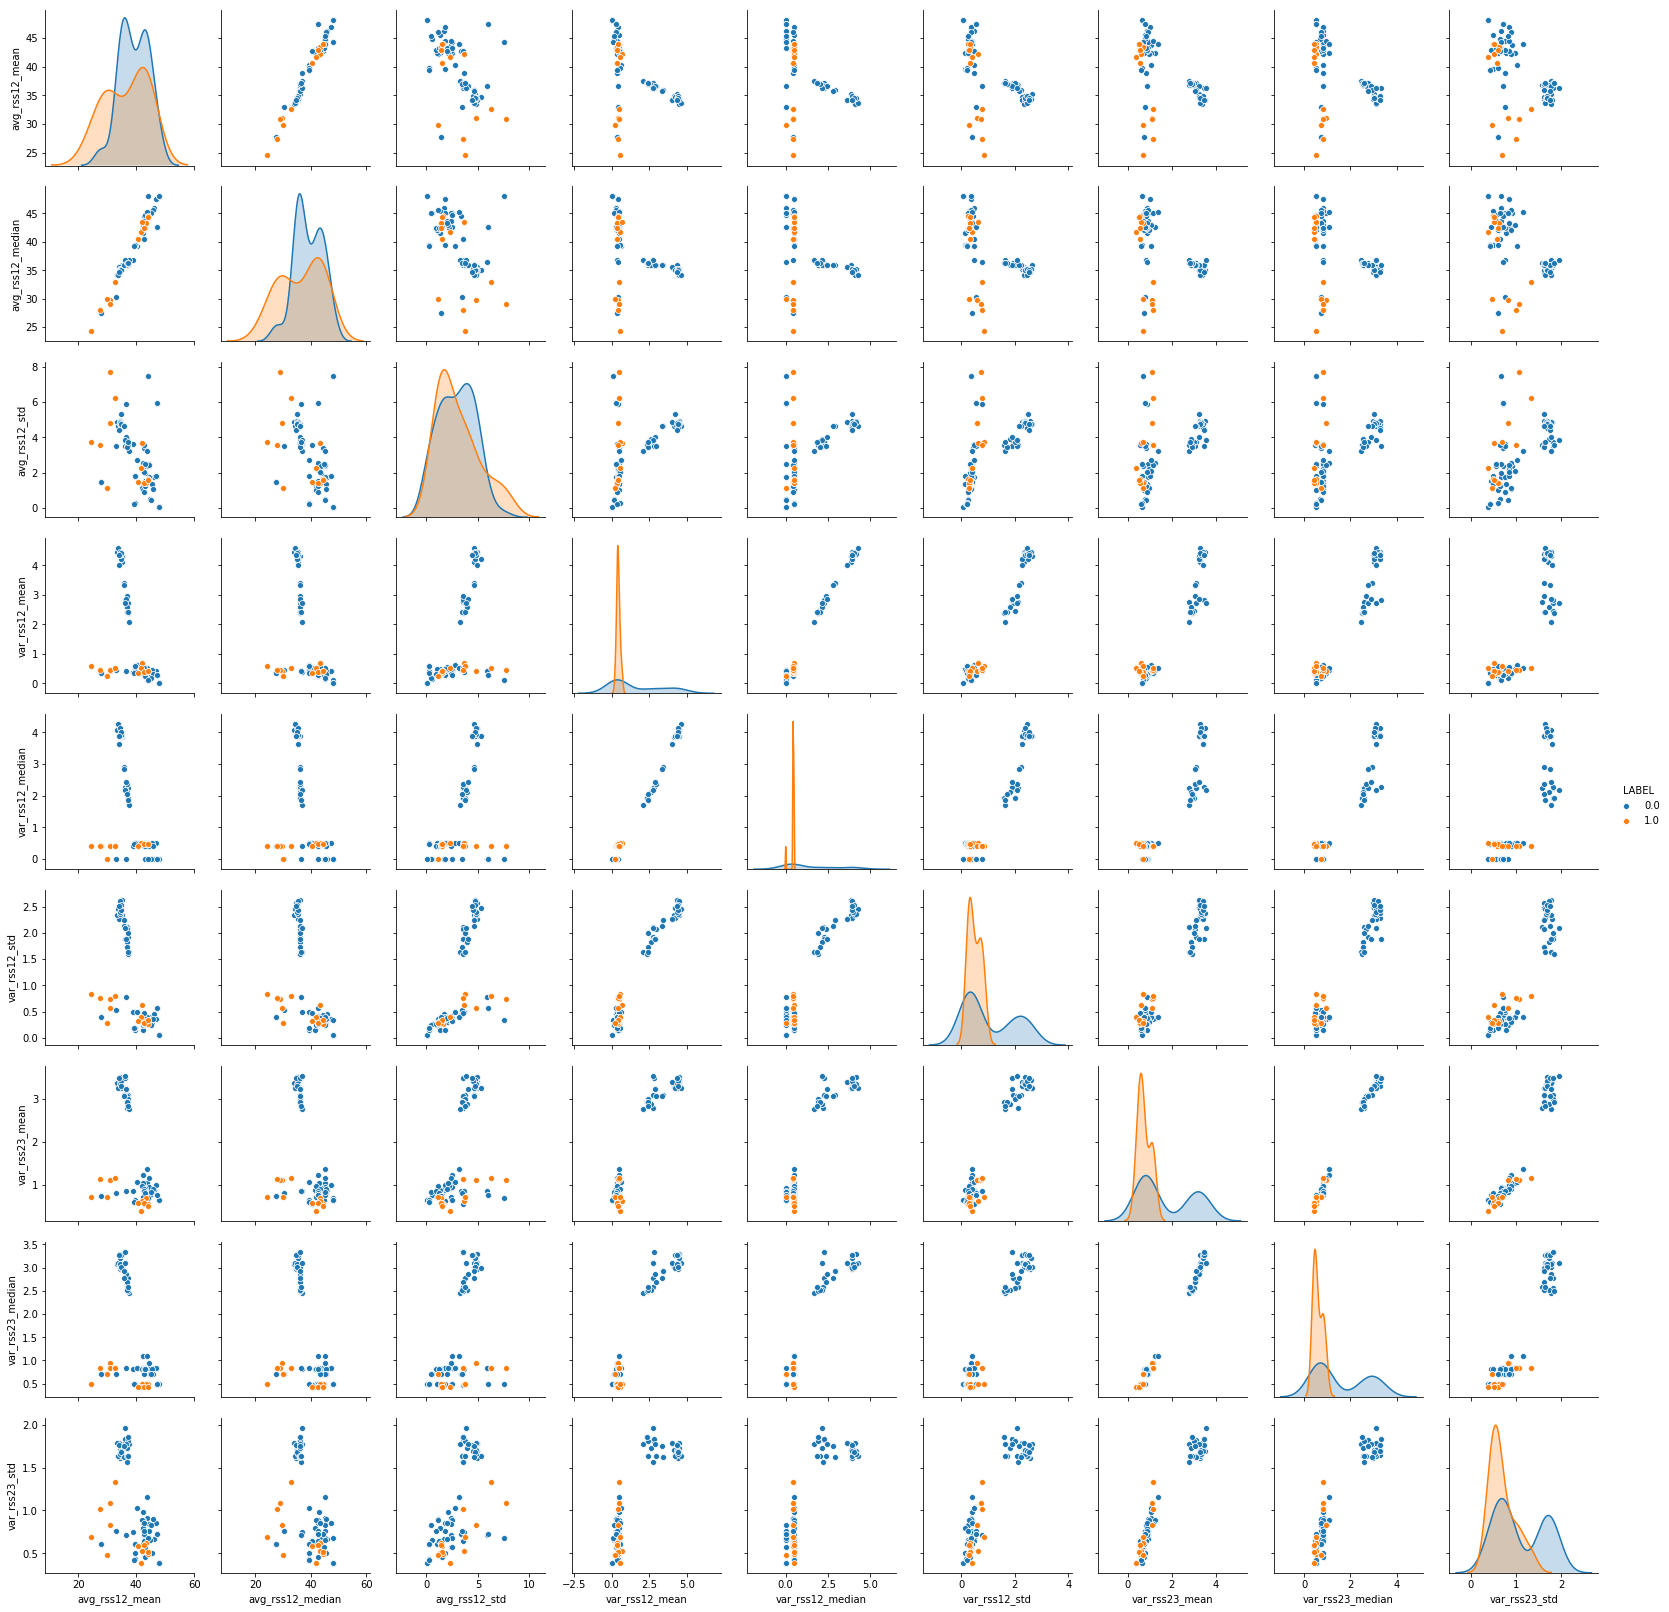

In [16]:
three_features = ['avg_rss12_mean','avg_rss12_median','avg_rss12_std',
                 'var_rss12_mean','var_rss12_median','var_rss12_std',
                 'var_rss23_mean','var_rss23_median','var_rss23_std']

sns.pairplot(df,vars = three_features,hue ='LABEL')

### The below function generates a list of attributes
The list is used as column names for each split of time series<br><br>
Notes on column names -<br>
Suppose we have to split each time series into 2, i.e l=2<br>
I have used the naming convention __timeseries_feature_splitno__<br>
For Example - For the time series avg_rss12 and feature mean, the first split will have the name - __avg_rss12_mean_1__

In [16]:
global str
def attribute_names(split=1):
    attributes = []
    pre_names = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    post_names = ['min','max','mean','median','std','first','third']
    for i in range(split):
        for pre in pre_names:
            for post in post_names:
                name = pre+'_'+post+'_'+str(i+1)
                attributes.append(name)
    attributes.append('LABEL')            
    return attributes

In [17]:
#Testing if the above function returns the correct number of attributes
print(len(attribute_names(1)))

43


### The below function generates index numbers based on which each time series is split
For ex. If we want to break a time series into two splits-<br>
For a dataframe of 480 observations - <br>
1. Indices for 1st split 0-240<br>
2. Indices for 2nd split 241-480

In [18]:
def index_generator(n):
    size = int(480/n)
    index = [0]
    for i in np.arange(1,n,1):
        index.append(index[i-1]+size)
    index.append(480)    
    return index

In [19]:
#Testing if the above function returns the correct indices
index_generator(7)

[0, 68, 136, 204, 272, 340, 408, 480]

### For splitting the dataframes into n approximately equal parts
This function splits the original time series into n splits based on the indices generated by the above function and returns a dictionary which contains the time domain features of all the split time series

In [20]:
def df_split(dataset,n,instance_name,temp_dict):
    colnames = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    rows = ['min','max','mean','50%','std','25%','75%']
    index = index_generator(n)
    list_op = []
    for i in range(len(index)-1):
        df = dataset.iloc[index[i]:index[i+1]]
        op = df.describe()
        for col in colnames:
            for row in rows:
                #print("Value at Row: "+row+" Col: "+col+"is:"+str(op[col][row]))
                list_op.append(op[col][row])
    if instance_name.startswith('bending'):
        list_op.append(1)
    else:
        list_op.append(0)
    #print("Length of list: "+str(len(list_op)))
    temp_dict[instance_name] = list_op
    return temp_dict

### The below function returns the name of the dataframe

In [21]:
#Taken from stackoverflow
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

### The below function will loop through the list of all train dataframes and split each timeseries into n splits

In [22]:
def main(n):
    attributes = attribute_names(n) #Obtain the attribute names for a given split
    print("Length of Attributes: "+str(len(attributes)))
    #print(attributes)
    dict_name = "dictionary"+"_"+str(n)
    vars()[dict_name] = {"Dataset instance": attributes}
    temp_dict = vars()[dict_name]
    for dataset in train_datasets:
        instance_name = get_df_name(dataset) #Get dataframe name
        temp_dict = df_split(dataset,n,instance_name,temp_dict)
    df = pd.DataFrame.from_dict(temp_dict, orient='index') #Converting the dictionary into a dataframe
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    print(df.shape)
    return df    

### The below function will loop through the list of all test dataframes and split each timeseries into n splits

In [23]:
#Testing if the above function returns the correct dataframe when split=2
df = main(2)
df.style

Length of Attributes: 85
(69, 85)


In [24]:
def main_test(n):
    attributes = attribute_names(n) #Obtain the attribute names for a given split
    print("Length of Attributes: "+str(len(attributes)))
    #print(attributes)
    dict_name = "dictionary"+"_"+str(n)
    vars()[dict_name] = {"Dataset instance": attributes}
    temp_dict = vars()[dict_name]
    for dataset in test_datasets:
        instance_name = get_df_name(dataset) #Get dataframe name
        temp_dict = df_split(dataset,n,instance_name,temp_dict)
    df = pd.DataFrame.from_dict(temp_dict, orient='index') #Converting the dictionary into a dataframe
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    print(df.shape)
    return df    

In [25]:
#Testing if the above function returns the correct dataframe when split=7
df_test = main_test(7)
df_test.style

Length of Attributes: 295
(19, 295)


## Scatterplot for split timeseries

In [26]:
df_split_2 = main(2) #Calling function to split the dataframe into n time series, in this case n=2
attributes_2 = attribute_names(2) #Obtaining the column names of the dataframe 

Length of Attributes: 85
(69, 85)


### Function to get the timeseries 1,2 and 6(Both Parts)
The below function returns the columns representing both parts of time series 1,2 and 6 (Only for features mean, median and std)

In [27]:
def get_pairplot_features(attributes):
    pairplot_features = []
    for attribute in attributes:
        if attribute.startswith('avg_rss12') or attribute.startswith('var_rss12') or attribute.startswith('var_rss23'):
            if (attribute.find("mean") != -1) or (attribute.find("median") != -1) or (attribute.find("std") != -1): 
                pairplot_features.append(attribute)
    #print(len(pairplot_features))
    return pairplot_features

### Pairplot representing the mean,median and std of each time series 1,2 and 6

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


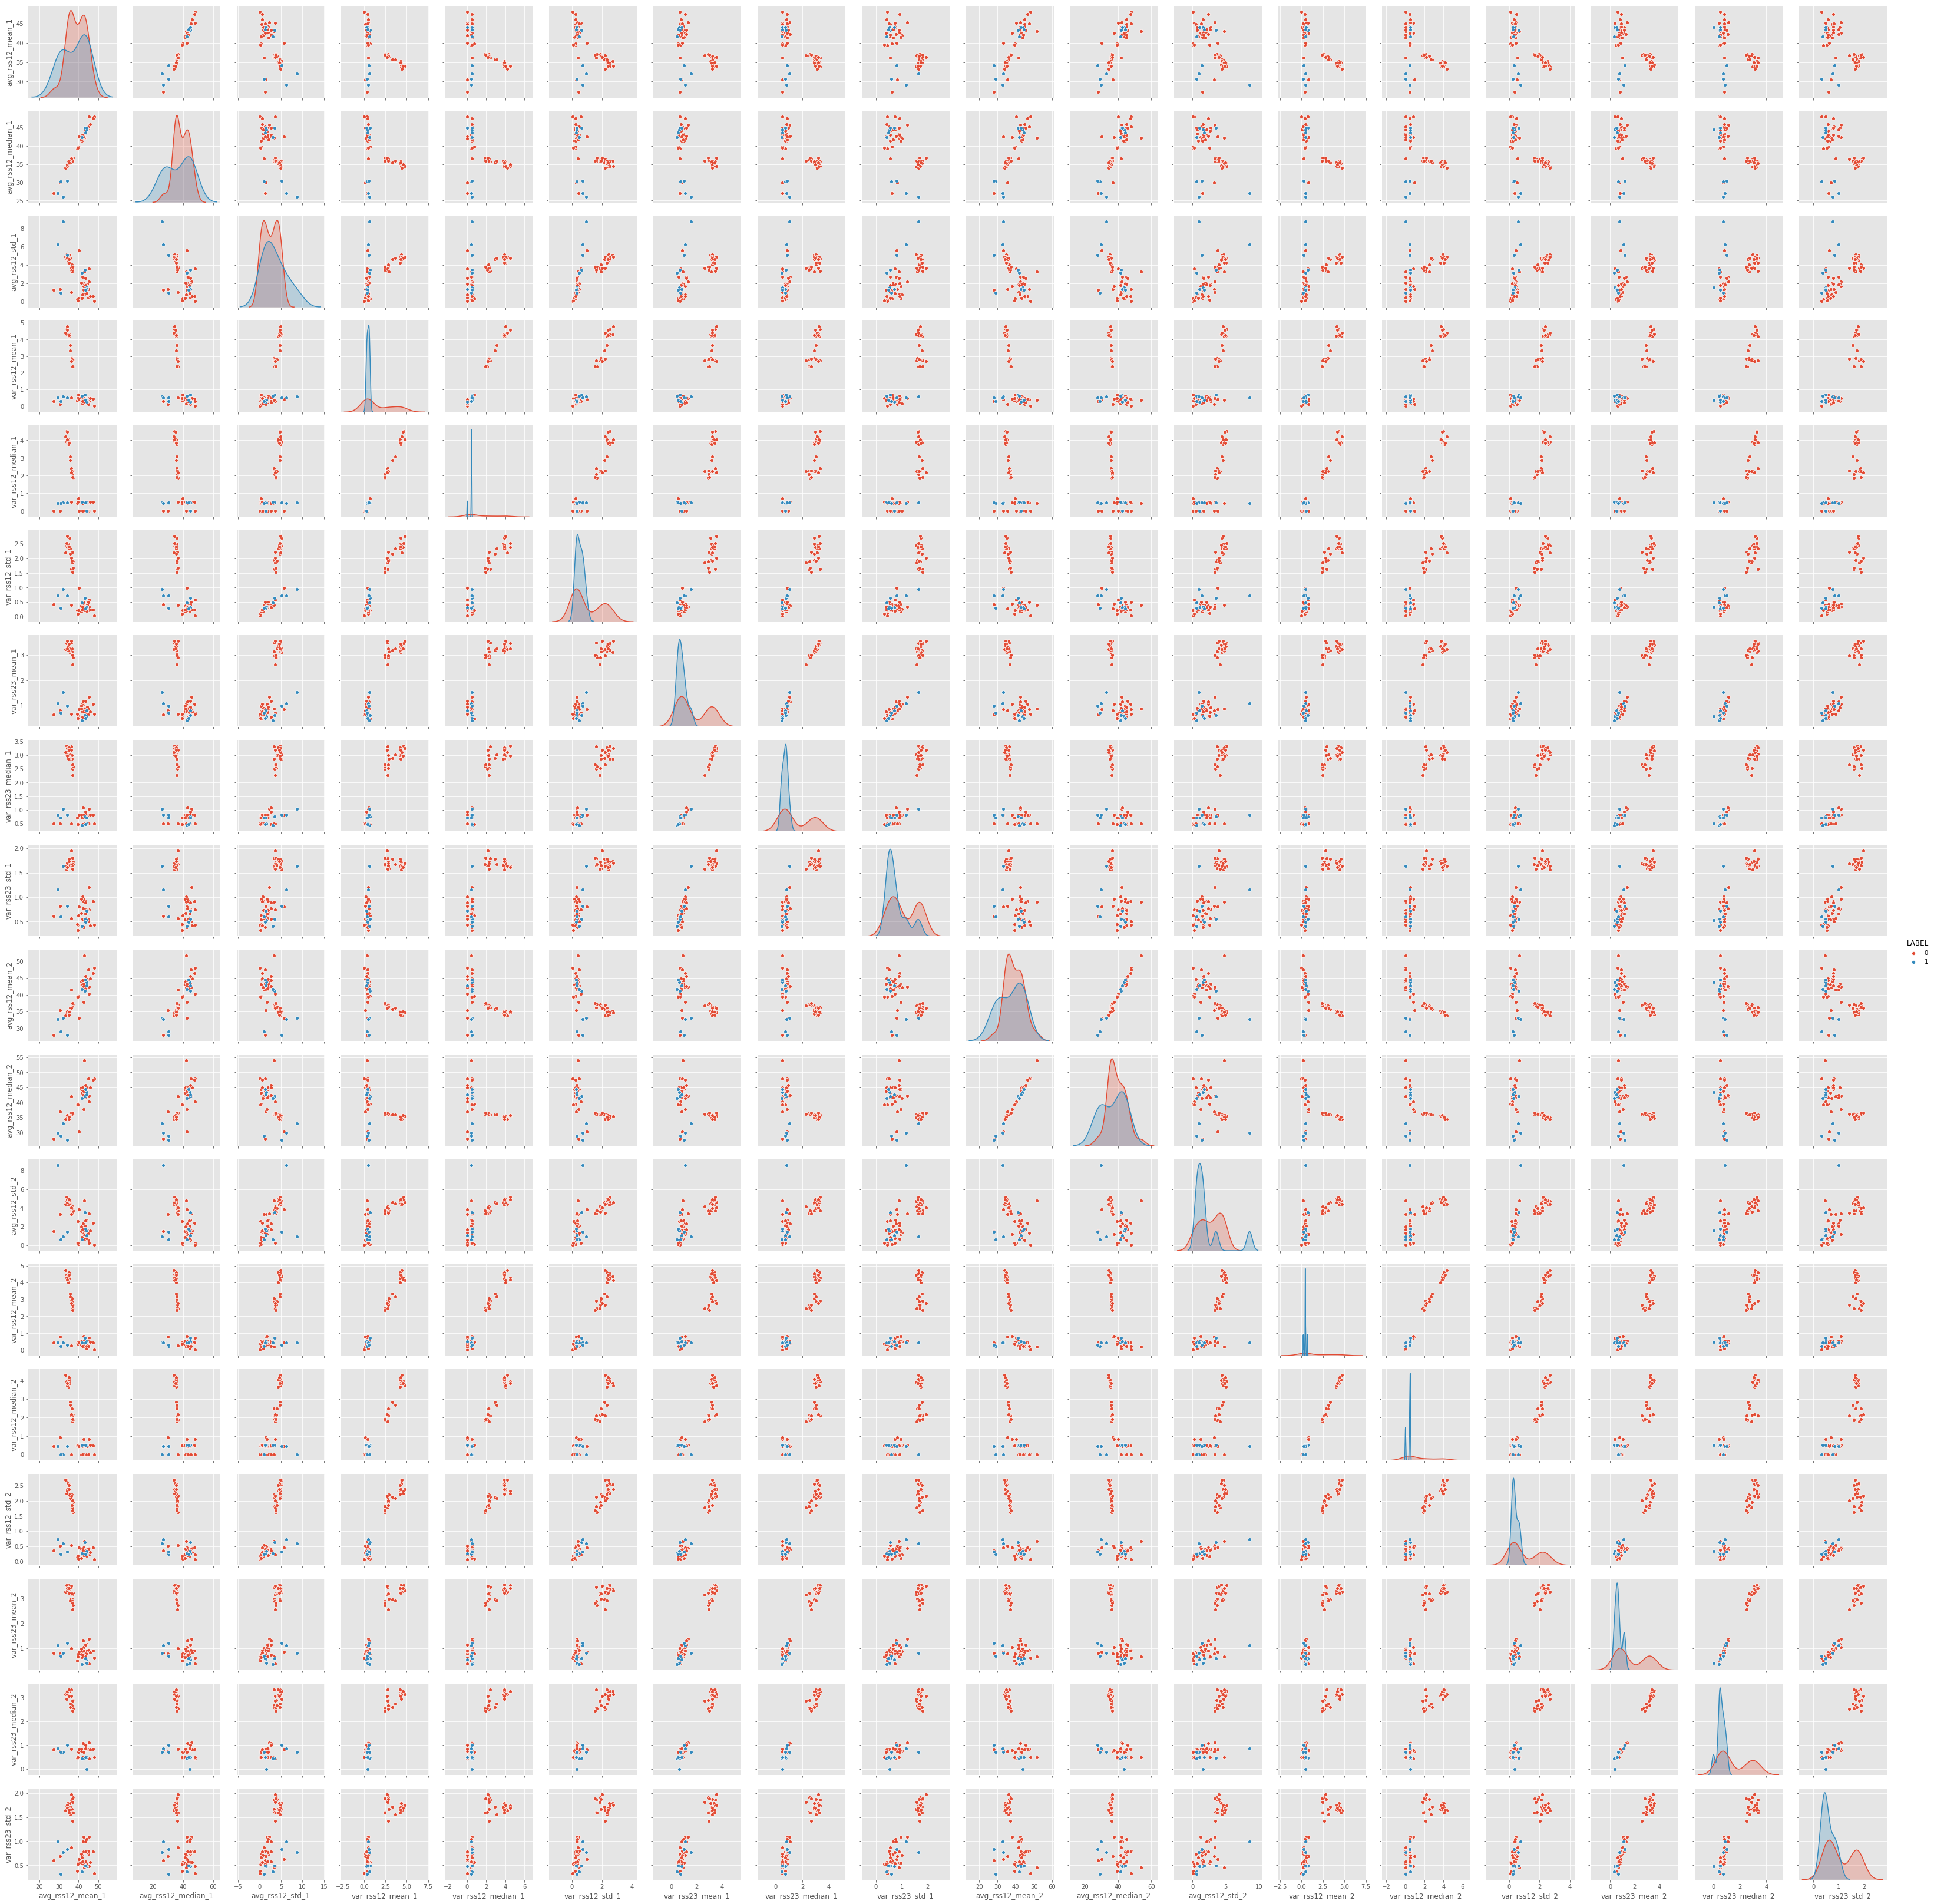

In [267]:
pairplot_features = get_pairplot_features(attributes_2)
sns.pairplot(df_split_2,vars = pairplot_features,hue ='LABEL')

On comparing the first scatter matrix(Scatterplots for time domain features mean,median and std for time series 1,2 and 6) with the second scatter matrix(Scatterplots for time domain features mean,median and std for time series 1,2 and 6 when they're split into 2) we can notice that there is no considerable difference.<br>
Therefore, splitting the time series doesn't affect the distribution of the data.

### LOGISITC REGRESSION

### Function which returns Train and Test dataset
The below function returns two dataframes -<br>
1. A dataframe with all training datasets split into n time series and associated time domain features.<br>
2. A dataframe with all test datasets split into n time series and associated time domain features.<br>

In [28]:
def form_train_test(n):
    train = main(n)
    test = main_test(n)
    return train,test

### Splitting the Training and Test data set into two seperate dataframes of __Independent__ variables and Dependent variables
The below function returns 4 dataframes -<br>
1. X_Train - Which contains all the independent features of the train dataframe.<br>
2. Y_Train - Which contains all the dependent features of the train dataframe.<br>
3. X_Test - Which contains all the independent features of the test dataframe.<br>
4. Y_Test - Which contains all the dependent features of the test dataframe.<br>

In [29]:
def form_X_Y_train_test(train,test):
    X_train = train.iloc[:,:-1]
    Y_train = train.iloc[:,-1:]
    X_train = X_train.iloc[:].astype('float')
    Y_train = (Y_train.astype('int').values)
    X_test = test.iloc[:,:-1]
    Y_test = test.iloc[:,-1:]
    X_test = X_test.iloc[:].astype('float')
    Y_test = (Y_test.astype('int').values)

    #model = sm.Logit(Y, X)
    #result = model.fit(method='bfgs')
    return X_train,Y_train,X_test,Y_test

### Recursive Feature Elimination and Cross Validation
#### Recursive Feature Elimination
Recursive Feature Elimination is a feature selection prcoess, it is a backward feature selection method where, insignificant features are removed based on the step size.<br>
In this case, I've made use of step size 1, where the least significant feature will be removed in every iteration.<br>
We keep doing this until the feature set cannot be reduced anymore.<br>

#### K-Fold Cross Validation -
K-Fold Cross Validation is used in machine learning to see how a model performs on unseen data.<br>
Suppose k is set to 2 - 
1. First, the data is split into 2(k) folds.
2. Then the model is trained on the first half of the data and tested on the second half of the data.
3. The above step is repeated, but in this case, the model is trained with the second half of the data and tested with the first half.
4. The mean of the performance parameter is taken and returned as the Cross Validation score.<br>

#### Correct way to do Recursive Feature Elimination and Cross Validation -
When we have a dataset with n features, we first perform cross validation using all the features and then also cross validate on the reduced feature set.<br>
The wrong approach would be first performing recursive feature elimination and then performing cross validation on the dataset using the reduced feature set only.<br>
__Note__ - We crossvalidate for each split of l, to obtain the best reduced feature set for each split l

### Function to implement Recursive Feature Elimination and Cross Validation
The below function does the following - <br>
1. Performs Recursive Feature Elimination with Cross Validation, I've made use of the RFECV function under sci-kit learn to do the same.<br>
2. The above step returns a list(of length same as the number of attributes) with boolean values(modelname.support_), using which the significant features can be extracted.<br>
3. The above funtion also returns grid scores(list of cross validation scores), using which, the best cross validation score can be found.<br>
4. We re-fit the model using the train data with only the reduced feature set(significant features), we then obtain test scores using the new model.<br><br>

To summarize, the below function returns the number of features selected by the recursive feature elimination with Cross Validation,the cross validation score of the model, the test score of the new model, the confusion matrix of the new model.

In [30]:
def run_rfe(X_train,Y_train,X_test,Y_test,i):
    shape = X_train.shape #Obtains the shape of the X_Train dataframe
    features = shape[1] #Obtains the number of columns in the X_Train dataframe
    
    model = LogisticRegression(solver='liblinear') #Initialising the Logisitic Regression Model
    print("Made the LR model")
    rfe =RFECV(model,min_features_to_select=1,cv=5) #Making use of the Recursive Feature Elimination with Cross Validation Library
    rfe = rfe.fit(X_train, Y_train.ravel()) #Fitting the model to the train dataset
    score = rfe.score(X_test,Y_test.ravel()) #Obtaining the test score of the model
    num_features = rfe.n_features_ #Obtaining the least number of features whihch results in highest Cross Validation Score
    max_score = max(rfe.grid_scores_) #Obtaining the highest CV Score
    
    #Forming a list with indices of the selected features
    attr_index = []
    for i,value in enumerate(rfe.support_):
        if value==True:
            attr_index.append(i)
    
    #Forming a new training set only with selected features
    temp = X_train
    new_train = temp.iloc[:,attr_index]
    
    #Using the estimator returned by the RFE model
    estimator = rfe.estimator_ #Best fit regression model 
    #Re-fitting the model to the new reduced train set
    rfe = estimator.fit(new_train, Y_train.ravel())
    
    Y_Pred = rfe.predict(X_test.iloc[:,attr_index])
    
    #Calculating the test score
    test_score = estimator.score(X_test.iloc[:,attr_index], Y_test.ravel())
    
    #Getting the confusion matrix for the above model
    conf_matrix = confusion_matrix(Y_test, Y_Pred)
    
    return num_features,max_score,test_score,conf_matrix

### Cell calling the aforementioned functions
In this cell, we loop through the splits(l) 1-20 to find the the best (l,p) pair, where p is the number of features.<br>
We make calls to the following functions - <br>
1. __form_train_test__ - to form the training and test dataframes for a given split.<br>
2. __form_X_Y_train_test__ - Splitting the train and test dataframe into seperate dataframes of independent and dependent dataframes.<br>
3. __run_rfe__ - To perform recursive feature elimination with cross validation.<br><br>

__Note__ - I've made print statements when Logistic Regression is completed for each split for me to track the progress of the loop. 

In [92]:
dict_summary = {}
p = []
score = []
test_scores = []
confusion_matrices = []
for i in range(1,21,1):
    train,test = form_train_test(i)
    X_train,Y_train,X_test,Y_test = form_X_Y_train_test(train,test)
    p_val,score_val,test_score,conf_matrix = run_rfe(X_train,Y_train,X_test,Y_test,i)
    score.append(score_val)    
    p.append(p_val)
    test_scores.append(test_score)
    confusion_matrices.append(conf_matrix)

Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)
Made the LR model
Length of Attributes: 85
(69, 85)
Length of Attributes: 85
(19, 85)
Made the LR model
Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)
Made the LR model
Length of Attributes: 169
(69, 169)
Length of Attributes: 169
(19, 169)
Made the LR model
Length of Attributes: 211
(69, 211)
Length of Attributes: 211
(19, 211)
Made the LR model
Length of Attributes: 253
(69, 253)
Length of Attributes: 253
(19, 253)
Made the LR model
Length of Attributes: 295
(69, 295)
Length of Attributes: 295
(19, 295)
Made the LR model
Length of Attributes: 337
(69, 337)
Length of Attributes: 337
(19, 337)
Made the LR model
Length of Attributes: 379
(69, 379)
Length of Attributes: 379
(19, 379)
Made the LR model
Length of Attributes: 421
(69, 421)
Length of Attributes: 421
(19, 421)
Made the LR model
Length of Attributes: 463
(69, 463)
Length of Attributes: 463
(19, 463)
Made the LR model
Length of Attribut

### Summarising the output of the above functions

In [93]:
dictionary_summary = {'Split(l)':range(1,21,1),
             'P':p,
             'CV Score':score,
             'Test Score':test_scores,
             'Confusion Matrix':confusion_matrices}
df_summary = pd.DataFrame(dictionary_summary)
df_summary.set_index('Split(l)')
df_summary.style

In [94]:
#Sorting the above dataframe
sorted_df = df_summary.sort_values(by=['CV Score'],ascending=False)
sorted_df.head(1)

Split(l)  P  CV Score  Test Score   Confusion Matrix
2         3  4       1.0         1.0  [[15, 0], [0, 4]]

From the above dataframe - we can see that the model has the highest cross validation score when each time series is split into 3 parts.<br>
After performing Recursive Feature Elimination we get a reduced feature set containing 4 features.

### The best (l,p) pair - (3,4), i.e. Split=3 and Number of features = 4

### Finding p-values and the Z-Score of the most significant features (Reduced Feature Set)
Code to calculate p-values taken from - 'https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d'

In [105]:
train,test = form_train_test(3)
X_train,Y_train,X_test,Y_test = form_X_Y_train_test(train,test)

model = LogisticRegression(solver='liblinear',max_iter=1000)
rfe =RFECV(model,min_features_to_select=1,cv=5)
rfe = rfe.fit(X_train, Y_train.ravel())
features = rfe.n_features_
score = max(rfe.grid_scores_)
print(features)
print(score)
attr_index = []
for i,value in enumerate(rfe.support_):
    if value==True:
        attr_index.append(i)
temp = X_train
new_train = temp.iloc[:,attr_index]

estimator = rfe.estimator_
rfe = estimator.fit(new_train, Y_train.ravel())

denom = (2.0*(1.0+np.cosh(estimator.decision_function(new_train))))
denom = np.tile(denom,(new_train.shape[1],1)).T
F_ij = np.dot((new_train/denom).T,new_train) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
z_scores = estimator.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
coefficients = list(estimator.coef_)

dictionary_pval = {"Attributes":new_train.columns,
                   "Coefficients":coefficients[0],
                  "Z-Score":z_scores,
                  "P-Values":p_values}
df_pval = pd.DataFrame(dictionary_pval)
df_pval.style

Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)
4
1.0


We obtain a test score of 1.0 comapred to the cross validation score of 0.985 we got for the same split. 

## ROC Curve
First, we run RFECV on the dataframe where the time series are split into 3 parts

In [31]:
train,test = form_train_test(3)
X_train,Y_train,X_test,Y_test = form_X_Y_train_test(train,test)

model = LogisticRegression(solver='liblinear',max_iter=1000) #Initialising the Logisitic Regression Model
rfe =RFECV(model,min_features_to_select=1,cv=5) #Making use of the Recursive Feature Elimination with Cross Validation Library
rfe = rfe.fit(X_train, Y_train.ravel()) 

attr_index = []
for i,value in enumerate(rfe.support_):
    if value==True:
        attr_index.append(i)
print("Number of features: {0}".format(len(attr_index)))
temp = X_train
new_train = temp.iloc[:,attr_index]
rfe = model.fit(new_train, Y_train.ravel())
#Y_Pred = model.predict(X_test.iloc[:,attr_index])
Y_Pred = model.predict(new_train)
print("Test score:{0}".format(model.score(X_test.iloc[:,attr_index], Y_test.ravel())))

Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)
Number of features: 4
Test score:1.0


### ROC curve and AUC for training data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00         9

   micro avg       1.00      1.00      1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

False Positive Rate: [0. 0. 1.]
True Positive Rate: [0. 1. 1.]
Thresholds: [2 1 0]



AUC is:1.0


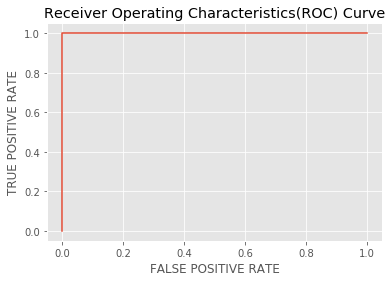

In [32]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
conf_matrix = confusion_matrix(Y_train, Y_Pred)
tp = conf_matrix[1][1]
tn = conf_matrix[0][0]
fn = conf_matrix[1][0]
fp = conf_matrix[0][1]

print(classification_report(Y_train, Y_Pred))

fpr, tpr, thresholds = metrics.roc_curve(Y_train.ravel(), Y_Pred)

print("False Positive Rate: {0}".format(fpr))
print("True Positive Rate: {0}".format(tpr))

#Decreasing thresholds on the decision function used to compute fpr and tpr. 
#thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.
print("Thresholds: {0}".format(thresholds)) 

plt.style.use("ggplot")
plt.plot(fpr,tpr)
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("Receiver Operating Characteristics(ROC) Curve")
print("\n\n")
print("AUC is:{0}".format(roc_auc_score(Y_train.ravel(), Y_Pred)))

### ROC curve and AUC for test data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         4

   micro avg       1.00      1.00      1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

False Positive Rate: [0. 0. 1.]
True Positive Rate: [0. 1. 1.]
Thresholds: [2 1 0]



AUC is:1.0


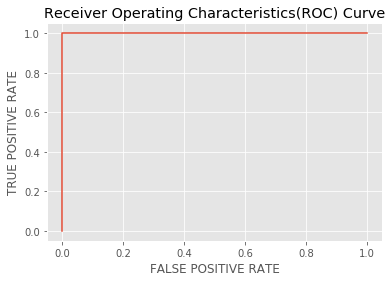

In [33]:
#Using only the extracted features from the test set to check the accuracy of the test set.
Y_Pred_test = model.predict(X_test.iloc[:,attr_index])

conf_matrix = confusion_matrix(Y_test, Y_Pred_test)
tp = conf_matrix[1][1]
tn = conf_matrix[0][0]
fn = conf_matrix[1][0]
fp = conf_matrix[0][1]

print(classification_report(Y_test.ravel(), Y_Pred_test))

fpr, tpr, thresholds = metrics.roc_curve(Y_test.ravel(), Y_Pred_test)

print("False Positive Rate: {0}".format(fpr))
print("True Positive Rate: {0}".format(tpr))

#Decreasing thresholds on the decision function used to compute fpr and tpr. 
#thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.
print("Thresholds: {0}".format(thresholds)) 

plt.style.use("ggplot")
plt.plot(fpr,tpr)
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("Receiver Operating Characteristics(ROC) Curve")
print("\n\n")
print("AUC is:{0}".format(roc_auc_score(Y_test.ravel(), Y_Pred_test)))

### Instability in calculating Logistic Regression Parameters -
Since the training and testing score is 1.0 in most cases, this is a clear sign of the classes(1-Bending & 0-Not Bending) being well separated.<br>

### Logistic Regression with case-control sampling -
We have 9 observeations for the class bending and 60 observations for the class not-bending.<br>
Generally, a dataset is said to be imbalanced if 80-90% of the observations fall into one of the classes.<br>
In this case, only 13% of the observations are categorized as bending. <br>

To tackle this, I've __downsampled__ the __majority class__(Not Bending) to 18 observations.<br>
Now, the ratio of bending to not bending is 1:2.<br><br>

I've also used __SMOTE__, for exploring the technique.

Note - I've made use of print statements to track the progress of the loop.

### Downsampling the majority class

In [121]:
dict_summary_downsample = {}
p_downsample = []
score_downsample = []
test_scores_downsample = []
confusion_matrices_downsample = []

for i in range(1,21,1):
    train,test = form_train_test(i)

    #Extracting majority and minority classes
    df_majority = train[df.LABEL==0]
    df_minority = train[df.LABEL==1]
 
    # Downsampling majority class
    df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=18,     # Using only 27 observations
                                 random_state=123) # reproducible results
 
    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    X_train,Y_train,X_test,Y_test = form_X_Y_train_test(df_downsampled,test)
    p_val,score_val,test_score,conf_matrix = run_rfe(X_train,Y_train,X_test,Y_test,i)

    score_downsample.append(score_val)    
    p_downsample.append(p_val)
    test_scores_downsample.append(test_score)
    confusion_matrices_downsample.append(conf_matrix)

Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)
Made the LR model
Length of Attributes: 85
(69, 85)
Length of Attributes: 85
(19, 85)
Made the LR model
Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)
Made the LR model
Length of Attributes: 169
(69, 169)
Length of Attributes: 169
(19, 169)
Made the LR model
Length of Attributes: 211
(69, 211)
Length of Attributes: 211
(19, 211)
Made the LR model
Length of Attributes: 253
(69, 253)
Length of Attributes: 253
(19, 253)
Made the LR model
Length of Attributes: 295
(69, 295)
Length of Attributes: 295
(19, 295)
Made the LR model
Length of Attributes: 337
(69, 337)
Length of Attributes: 337
(19, 337)
Made the LR model
Length of Attributes: 379
(69, 379)
Length of Attributes: 379
(19, 379)
Made the LR model
Length of Attributes: 421
(69, 421)
Length of Attributes: 421
(19, 421)
Made the LR model
Length of Attributes: 463
(69, 463)
Length of Attributes: 463
(19, 463)
Made the LR model
Length of Attribut

### Summarizing the results after downsampling majority class

In [123]:
dictionary_summary = {'Split(l)':range(1,21,1),
             'P':p_downsample,
             'CV Score':score_downsample,
             'Test Score':test_scores_downsample,
             'Confusion Matrix':confusion_matrices_downsample}

df_summary = pd.DataFrame(dictionary_summary)
df_summary.set_index('Split(l)')
df_summary.style

In [125]:
#Sorting the above dataframe
sorted_df = df_summary.sort_values(by=['CV Score'],ascending=False)
sorted_df.head(1)

Split(l)   P  CV Score  Test Score   Confusion Matrix
0         1  10       1.0         1.0  [[15, 0], [0, 4]]

### The best (l,p) pair - (1,10), i.e. Split=1 and Number of features = 10

### ROC curve for test data

Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)
Number of features: 10
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         4

   micro avg       1.00      1.00      1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

False Positive Rate: [0. 0. 1.]
True Positive Rate: [0. 1. 1.]
Thresholds: [2 1 0]



AUC is:1.0


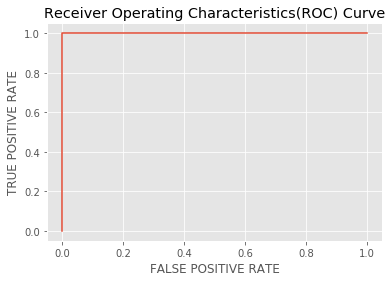

In [127]:
train,test = form_train_test(1)
#Extracting majority and minority classes
df_majority = train[df.LABEL==0]
df_minority = train[df.LABEL==1]
 
# Downsampling majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=18,     # Using only 27 observations
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

X_train,Y_train,X_test,Y_test = form_X_Y_train_test(df_downsampled,test)

model = LogisticRegression(solver='liblinear',max_iter=1000) #Initialising the Logisitic Regression Model
rfe =RFECV(model,min_features_to_select=1,cv=5) #Making use of the Recursive Feature Elimination with Cross Validation Library
rfe = rfe.fit(X_train, Y_train.ravel()) 

attr_index = []
for i,value in enumerate(rfe.support_):
    if value==True:
        attr_index.append(i)

print("Number of features: {0}".format(len(attr_index)))
temp = X_train
new_train = temp.iloc[:,attr_index]

rfe = model.fit(new_train, Y_train.ravel())
#Y_Pred = model.predict(X_test.iloc[:,attr_index])

Y_Pred = model.predict(new_train)

Y_Pred_test = model.predict(X_test.iloc[:,attr_index])

conf_matrix = confusion_matrix(Y_test, Y_Pred_test)
tp = conf_matrix[1][1]
tn = conf_matrix[0][0]
fn = conf_matrix[1][0]
fp = conf_matrix[0][1]

print(classification_report(Y_test.ravel(), Y_Pred_test))

fpr, tpr, thresholds = metrics.roc_curve(Y_test.ravel(), Y_Pred_test)

print("False Positive Rate: {0}".format(fpr))
print("True Positive Rate: {0}".format(tpr))

#Decreasing thresholds on the decision function used to compute fpr and tpr. 
#thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.
print("Thresholds: {0}".format(thresholds)) 

plt.style.use("ggplot")
plt.plot(fpr,tpr)
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("Receiver Operating Characteristics(ROC) Curve")
print("\n\n")
print("AUC is:{0}".format(roc_auc_score(Y_test.ravel(), Y_Pred_test)))

### SMOTE

In [426]:
from imblearn.over_sampling import SMOTE
dict_summary_smote = {}
p_smote = []
score_smote = []
test_scores_smote = []
confusion_matrices_smote = []
for i in range(1,21,1):
    train,test = form_train_test(i)
    X_train,Y_train,X_test,Y_test = form_X_Y_train_test(train,test)

    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Y_train.ravel())
    X_res = pd.DataFrame(data=X_res,columns = attribute_names(i)[:-1])
    
    p_val,score_val,test_score,conf_matrix = run_rfe(X_res,y_res,X_test,Y_test,i)
    score_smote.append(score_val)    
    p_smote.append(p_val)
    test_scores_smote.append(test_score)
    confusion_matrices_smote.append(conf_matrix)

Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)
Made the LR model
Length of Attributes: 85
(69, 85)
Length of Attributes: 85
(19, 85)
Made the LR model
Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)
Made the LR model
Length of Attributes: 169
(69, 169)
Length of Attributes: 169
(19, 169)
Made the LR model
Length of Attributes: 211
(69, 211)
Length of Attributes: 211
(19, 211)
Made the LR model
Length of Attributes: 253
(69, 253)
Length of Attributes: 253
(19, 253)
Made the LR model
Length of Attributes: 295
(69, 295)
Length of Attributes: 295
(19, 295)
Made the LR model
Length of Attributes: 337
(69, 337)
Length of Attributes: 337
(19, 337)
Made the LR model
Length of Attributes: 379
(69, 379)
Length of Attributes: 379
(19, 379)
Made the LR model
Length of Attributes: 421
(69, 421)
Length of Attributes: 421
(19, 421)
Made the LR model
Length of Attributes: 463
(69, 463)
Length of Attributes: 463
(19, 463)
Made the LR model
Length of Attribut

### Summarizing the results after using SMOTE
We can notice from the dataframe below that the Cross Validation score improves for all splits after performing SMOTE

In [427]:
dictionary_summary = {'Split(l)':range(1,21,1),
             'P':p_smote,
             'CV Score':score_smote,
             'Test Score':test_scores_smote,
             'Confusion Matrix':confusion_matrices_smote}
df_summary = pd.DataFrame(dictionary_summary)
df_summary.set_index('Split(l)')
df_summary.style

## Lasso Regression(L1-Penalized Logistic Regression)<br>
1. I've made use of the LassoCV function to cross validate for the value of __lambda(λ)__.<br>
2. LassoCV automatically normalizes the data when we set the __normalize__ parameter to __True__.<br>
3. The LassoCV model is fitted to the train date, using which it performs cross validation for the best value of lambda.<br>
4. The model also __reduces__ the the coefficients of the __insignificant__ features to __0__, using which the reduced set of significant features can be extracted.<br><br>

Using the __lambda(λ)__ value obtained from lassoCV, we set the budget of the logisitc regression model(c = 1/λ). We then train the logisitic regression model on the training data and obtain the train and the test score.<br>


Note - I've made use of print statements to track the progress of the loop.

In [83]:
score_lasso = []
list_of_attributes_per_split = []
coeff_used = []
lambda_lasso = []
test_score_lasso = []
train_score_lasso = []
count = 0
for i in range(1,21,1):
    print("Lasso Regression for split: "+str(i))
    train,test = form_train_test(i)
    X_train,Y_train,X_test,Y_test = form_X_Y_train_test(train,test)
    
    #Implementing Lasso Regression with CV for each split
    lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)#Normalizing the data
    
    lassocv.fit(X_train, Y_train.ravel())
    
    #Appending the score, number of attributes selected and the lambda selected by the model
    score_lasso.append(lassocv.score(X_test,Y_test))
    coeff_used.append(np.sum(lassocv.coef_!=0))
    lambda_lasso.append(lassocv.alpha_)
    
    #Extracting coefficients used -
    #Obtaining the indices of the attributes selected
    attr_index = []
    for i,value in enumerate(lassocv.coef_):
        if value!=0:
            attr_index.append(i)
    #Selecting the attributes names
    split_attributes_lasso = attribute_names(i) #Calling functions to return attribute names for each split
    split_attributes_selected = []
    for i in attr_index:
        split_attributes_selected.append(split_attributes_lasso[i])
    list_of_attributes_per_split.append(split_attributes_selected)
    
    #Re-fitting the model with the tuned hyperparameter
    new_c = 1/lassocv.alpha_ #Budget C=1/lambda 
    lr_model = LogisticRegression(penalty='l1',solver='liblinear',max_iter=10000,C=new_c)
    lr_model_fitted = lr_model.fit(X_train, Y_train.ravel())
    
    #Appending the train score to a list
    train_score_lasso.append(lr_model_fitted.score(X_train,Y_train.ravel()))
    
    #Appending the test score to a list
    test_score_lasso.append(lr_model_fitted.score(X_test,Y_test.ravel()))

Lasso Regression for split: 1
Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)
Lasso Regression for split: 2
Length of Attributes: 85
(69, 85)
Length of Attributes: 85
(19, 85)
Lasso Regression for split: 3
Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)
Lasso Regression for split: 4
Length of Attributes: 169
(69, 169)
Length of Attributes: 169
(19, 169)
Lasso Regression for split: 5
Length of Attributes: 211
(69, 211)
Length of Attributes: 211
(19, 211)
Lasso Regression for split: 6
Length of Attributes: 253
(69, 253)
Length of Attributes: 253
(19, 253)
Lasso Regression for split: 7
Length of Attributes: 295
(69, 295)
Length of Attributes: 295
(19, 295)
Lasso Regression for split: 8
Length of Attributes: 337
(69, 337)
Length of Attributes: 337
(19, 337)
Lasso Regression for split: 9
Length of Attributes: 379
(69, 379)
Length of Attributes: 379
(19, 379)
Lasso Regression for split: 10
Length of Attributes: 421
(69, 421)
Length of Attributes: 4

### Forming a summary dataframe

In [84]:
#Forming a Summary Dictionary
dict_summary_lasso = {"Split": np.arange(1,21,1),
                      "Lambda":lambda_lasso,
                      "Score":score_lasso,
                      "Train Score":train_score_lasso,
                      "Test Score":test_score_lasso,
                      "Number of Attributes":coeff_used,
                      "Features selected":list_of_attributes_per_split}

#Forming a Summary Dataframe
df_summary_lasso = pd.DataFrame(dict_summary_lasso)
df_summary_lasso.style

### Finding the best (l,p) Pair
Note - Finding the lowest split of l which returns the highest test score.

In [98]:
sorted_df = df_summary_lasso.copy()
sorted_df = sorted_df[sorted_df['Test Score']==sorted_df['Test Score'].max()]
sorted_df = sorted_df[sorted_df['Split']==sorted_df['Split'].min()]
sorted_df.head(1)

Split    Lambda     Score  Train Score  Test Score  Number of Attributes  \
0      1  0.002682  0.738635          1.0         1.0                     7   

                                   Features selected  
0  [avg_rss12_third_1, avg_rss13_third_1, avg_rss...

### The best (l,p) pair - (1,7), i.e. Split=1 and Number of features = 7

### Comparing Lasso with variable selection using p-values
Recursive feature elimination is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. Features are then ranked according to when they were eliminated. As such, it is a greedy optimization for finding the best performing subset of features.
Though RFE reaps its own benefits, its computationally very expensive. And since it's built on so many assumptions, it's not always the best method to go by.<br><br>

In simple mathematical terms, Lasso shrinks and reduces the coeffients of the insignificant features, this will help reduce the variance without a substantial increase in bias. Lasso also offers more insight into the data and also helps in avoiding overfitting of the train data.<br><br>

To summarize, __Lasso__ is the easier and the computationally __superior__ model.



## Function for splitting the dataframes into n approximately equal parts
This function splits the original time series into n splits based on the indices generated by the function defined earlier in the notebook and returns a dictionary

In [34]:
def df_split_all_features(dataset,n,instance_name,activity,temp_dict):
    colnames = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    rows = ['min','max','mean','50%','std','25%','75%']
    index = index_generator(n)
    list_op = []
    for i in range(len(index)-1):
        df = dataset.iloc[index[i]:index[i+1]]
        op = df.describe()
        for col in colnames:
            for row in rows:
                #print("Value at Row: "+row+" Col: "+col+"is:"+str(op[col][row]))
                list_op.append(op[col][row])
    list_op.append(activity)
    #print("Length of list: "+str(len(list_op)))
    temp_dict[instance_name] = list_op
    return temp_dict

### The below function will loop through the list of all train dataframes and split each timeseries into n splits

In [35]:
def main_all_features(n):
    attributes = attribute_names(n)
    print("Length of Attributes: "+str(len(attributes)))
    #print(attributes)
    dict_name = "dictionary"+"_"+str(n)
    vars()[dict_name] = {"Dataset instance": attributes}
    temp_dict = vars()[dict_name]
    for dataset in train_datasets:
        instance_name = get_df_name(dataset)
        activity = instance_name.split(sep="_")[0]
        temp_dict = df_split_all_features(dataset,n,instance_name,activity,temp_dict)
    df_all_features = pd.DataFrame.from_dict(temp_dict, orient='index')
    df_all_features.columns = df_all_features.iloc[0]
    df_all_features = df_all_features.iloc[1:]
    print(df_all_features.shape)
    return df_all_features    

In [36]:
#Testing if the above function returns the correct dataframe when split=7
df_all_features = main_all_features(2)
df_all_features.style

Length of Attributes: 85
(69, 85)


### The below function will loop through the list of all test dataframes and split each timeseries into n splits

In [37]:
def main_test_all_features(n):
    attributes = attribute_names(n)
    print("Length of Attributes: "+str(len(attributes)))
    #print(attributes)
    dict_name = "dictionary"+"_"+str(n)
    vars()[dict_name] = {"Dataset instance": attributes}
    temp_dict = vars()[dict_name]
    for dataset in test_datasets:
        instance_name = get_df_name(dataset)
        activity = instance_name.split(sep="_")[0]
        temp_dict = df_split_all_features(dataset,n,instance_name,activity,temp_dict)
    df_all_features = pd.DataFrame.from_dict(temp_dict, orient='index')
    df_all_features.columns = df_all_features.iloc[0]
    df_all_features = df_all_features.iloc[1:]
    print(df_all_features.shape)
    return df_all_features  

In [38]:
#Testing if the above function returns the correct dataframe when split=2
df_test_all_features = main_test_all_features(2)
df_test_all_features.style

Length of Attributes: 85
(19, 85)


### Function which returns Train and Test dataset
The below function returns two dataframes -<br>
1. A dataframe with all training datasets split into n time series and associated time domain features.<br>
2. A dataframe with all test datasets split into n time series and associated time domain features.<br>

In [39]:
def form_train_test_all_features(n):
    train = main_all_features(n)
    test = main_test_all_features(n)
    return train,test

### Splitting the Training and Test data set into two seperate dataframes of __Independent__ variables and Dependent variables
The below function returns 4 dataframes -<br>
1. X_Train - Which contains all the independent features of the train dataframe.<br>
2. Y_Train - Which contains all the dependent features of the train dataframe.<br>
3. X_Test - Which contains all the independent features of the test dataframe.<br>
4. Y_Test - Which contains all the dependent features of the test dataframe.<br>
It also changes the labels of ['bending1','bending2','cycling','lying','sitting','standing','walking'] to [1,2,3,4,5,6,7]. (This is because sci-kit learn packages cannot classify data using labels)


In [40]:
def form_X_Y_train_test_all_features(train,test):
    
    train['LABEL'].replace('bending1',1,inplace=True)
    train['LABEL'].replace('bending2',2,inplace=True)
    train['LABEL'].replace('cycling',3,inplace=True)
    train['LABEL'].replace('lying',4,inplace=True)
    train['LABEL'].replace('sitting',5,inplace=True)
    train['LABEL'].replace('standing',6,inplace=True)
    train['LABEL'].replace('walking',7,inplace=True)

    test['LABEL'].replace('bending1',1,inplace=True)
    test['LABEL'].replace('bending2',2,inplace=True)
    test['LABEL'].replace('cycling',3,inplace=True)
    test['LABEL'].replace('lying',4,inplace=True)
    test['LABEL'].replace('sitting',5,inplace=True)
    test['LABEL'].replace('standing',6,inplace=True)
    test['LABEL'].replace('walking',7,inplace=True)
    
    X_train = train.iloc[:,:-1]
    Y_train = train.iloc[:,-1:]
    X_train = X_train.iloc[:].astype('float')
    Y_train = (Y_train.values)
    X_test = test.iloc[:,:-1]
    Y_test = test.iloc[:,-1:]
    X_test = X_test.iloc[:].astype('float')
    Y_test = (Y_test.values)

    #model = sm.Logit(Y, X)
    #result = model.fit(method='bfgs')
    return X_train,Y_train,X_test,Y_test

## L1-Penalized Multi Class Classification<br>
1. I've made use of the LassoCV function to cross validate for the value of __lambda(λ)__.<br>
2. LassoCV automatically normalizes the data when we set the __normalize__ parameter to __True__.<br>
3. The LassoCV model is fitted to the train date, using which it performs cross validation for the best value of lambda.<br>
4. The model also __reduces__ the the coefficients of the __insignificant__ features to __0__, using which the reduced set of significant features can be extracted.<br><br>

Using the __lambda(λ)__ value obtained from lassoCV, we set the budget of the logisitc regression model(c = 1/λ). We then train the logisitic regression model on the training data and obtain the train and the test score.<br>


Note - <br>
1. I've made use of print statements to track the progress of the loop.
2. LassoCV throws a warning that "minimum number of members in any class cannot be less than n_splits=5", I've taken care of this by using __StratifiedKFold__

In [89]:
score_lasso_multinomial = []
list_of_attributes_per_split_multinomial = []
coeff_used_multinomial = []
lambda_lasso_multinomial = []
test_score_multinomial = []
test_error_multinomial = []
train_score_multinomial = []
count = 0

for i in range(1,21,1):
    print("Lasso Regression for split: "+str(i))
    #Obtaining train and test data
    train,test = form_train_test_all_features(i)

    X_train,Y_train,X_test,Y_test = form_X_Y_train_test_all_features(train,test)\
    
    #Implementing LassoCV to obtain the best value of lambda
    lassocv = LassoCV(alphas = None, cv = StratifiedKFold(5), max_iter = 100000, normalize = True)
    lassocv.fit(X_train, Y_train.ravel())

    #Appending the score, number of attributes selected and the lambda selected by the model
    score_lasso_multinomial.append(lassocv.score(X_test,Y_test.ravel()))
    coeff_used_multinomial.append(np.sum(lassocv.coef_!=0))
    lambda_lasso_multinomial.append(lassocv.alpha_)
    
    #Extracting coefficients used -
    #Obtaining the indices of the attributes selected
    attr_index = []
    for i,value in enumerate(lassocv.coef_):
        if value!=0:
            attr_index.append(i)
    
    #Re-fitting the model with the tuned hyperparameter
    new_c = 1/lassocv.alpha_ #Budget C=1/lambda, 
    lr_model = LogisticRegression(penalty='l1',solver='saga',max_iter=10000,multi_class='multinomial',C=new_c)
    lr_model_fitted = lr_model.fit(X_train, Y_train.ravel())

    #Appending the train score to a list
    train_score_multinomial.append(lr_model_fitted.score(X_train,Y_train.ravel()))
    
    #Appending the test score to a list
    test_score_temp = lr_model_fitted.score(X_test,Y_test.ravel())
    test_score_multinomial.append(lr_model_fitted.score(X_test,Y_test.ravel()))
    test_error_temp = 1-test_score_temp
    test_error_multinomial.append(test_error_temp)

Lasso Regression for split: 1
Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 2
Length of Attributes: 85
(69, 85)
Length of Attributes: 85
(19, 85)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 3
Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 4
Length of Attributes: 169
(69, 169)
Length of Attributes: 169
(19, 169)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 5
Length of Attributes: 211
(69, 211)
Length of Attributes: 211
(19, 211)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 6
Length of Attributes: 253
(69, 253)
Length of Attributes: 253
(19, 253)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 7
Length of Attributes: 295
(69, 295)
Length of Attributes: 295
(19, 295)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 8
Length of Attributes: 337
(69, 337)
Length of Attributes: 337
(19, 337)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 9
Length of Attributes: 379
(69, 379)
Length of Attributes: 379
(19, 379)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 10
Length of Attributes: 421
(69, 421)
Length of Attributes: 421
(19, 421)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 11
Length of Attributes: 463
(69, 463)
Length of Attributes: 463
(19, 463)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 12
Length of Attributes: 505
(69, 505)
Length of Attributes: 505
(19, 505)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 13
Length of Attributes: 547
(69, 547)
Length of Attributes: 547
(19, 547)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 14
Length of Attributes: 589
(69, 589)
Length of Attributes: 589
(19, 589)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 15
Length of Attributes: 631
(69, 631)
Length of Attributes: 631
(19, 631)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 16
Length of Attributes: 673
(69, 673)
Length of Attributes: 673
(19, 673)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 17
Length of Attributes: 715
(69, 715)
Length of Attributes: 715
(19, 715)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 18
Length of Attributes: 757
(69, 757)
Length of Attributes: 757
(19, 757)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 19
Length of Attributes: 799
(69, 799)
Length of Attributes: 799
(19, 799)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Lasso Regression for split: 20
Length of Attributes: 841
(69, 841)
Length of Attributes: 841
(19, 841)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


### Forming a summary dataframe of the values obtained from the above cell

In [99]:
#Forming a Summary Dictionary
dict_summary_lasso_multinomial = {"Split": np.arange(1,21,1),
                      "Lambda":lambda_lasso_multinomial,
                      "Score":score_lasso_multinomial,
                      "Number of Attributes":coeff_used_multinomial,
                      "Train Score":train_score_multinomial,            
                      "Test Score":test_score_multinomial,
                      "Test Error":test_error_multinomial}

#"Attributes selected":list_of_attributes_per_split_multinomial
#Forming a Summary Dataframe
df_summary_lasso_multinomial = pd.DataFrame(dict_summary_lasso_multinomial)
df_summary_lasso_multinomial.style

### Finding the best (l,p) Pair
Note - Finding the lowest split of l which returns the highest test score.

In [100]:
sorted_df = df_summary_lasso_multinomial.copy()
sorted_df = sorted_df[sorted_df['Test Score']==sorted_df['Test Score'].max()]
sorted_df = sorted_df[sorted_df['Split']==sorted_df['Split'].min()]
sorted_df.head(1)

Split    Lambda     Score  Number of Attributes  Train Score  Test Score  \
1      2  0.012836  0.625797                    13          1.0    0.947368   

   Test Error  
1    0.052632

### The best (l,p) pair - (2,13), i.e. Split=2 and Number of features = 13

## Function to plot Confusion Matrix for Multinomial Classification
Taken from - https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Confusion Matrix for the LassoCV model with the highest score -
In this case - for __l=2__

Length of Attributes: 85
(69, 85)
Length of Attributes: 85
(19, 85)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


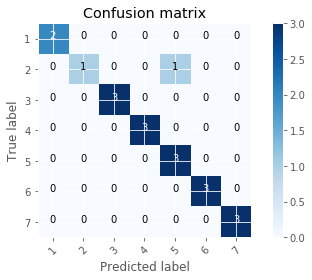

In [101]:
train,test = form_train_test_all_features(2)

X_train,Y_train,X_test,Y_test = form_X_Y_train_test_all_features(train,test)

lassocv = LassoCV(alphas = None, cv = StratifiedKFold(5), max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train.ravel())

#Appending the score, number of attributes selected and the lambda selected by the model

number_features = np.sum(lassocv.coef_!=0)
lasso_lambda = lassocv.alpha_
    
#Extracting coefficients used -
#Obtaining the indices of the attributes selected
attr_index = []
for i,value in enumerate(lassocv.coef_):
    if value!=0:
        attr_index.append(i)

#Re-fitting the model with the tuned hyperparameter
new_c = 1/lassocv.alpha_ #Budget C=1/lambda
model = LogisticRegression(penalty='l1',solver='saga',max_iter=10000,multi_class='multinomial',C=new_c)
fitted_model = model.fit(X_train, Y_train.ravel())

Y_Pred = fitted_model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_Pred,labels=[1,2,3,4,5,6,7])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5,6,7],
                      title='Confusion matrix')

## ROC Curve for Multinomial Classification
In a multi-class problem, to plot ROC curves, the idea is generally to carry out __pairwise comparison__ (one class vs. all other classes).<br>
Due to which we'll have __n__ ROC curves, where __n__ is the __number of classes__.<br>


## Naive Bayes' Classifier
### Gaussian Implementation - <br>
Note - I've made use print statements to track progress of the loop

In [62]:
gaussian_nbc_train_score = []
gaussian_nbc_test_score = []
gaussian_nbc_test_error = []

for i in range(1,21,1):
    train,test = form_train_test_all_features(i)

    X_train,Y_train,X_test,Y_test = form_X_Y_train_test_all_features(train,test)
    
    #Initialising Gaussian Naive Bayes' Classifier
    clf = GaussianNB()
    clf.fit(X_train, Y_train.ravel()) #Fitting the model to the trainig data
    target_pred = clf.predict(X_train)
    
    #Calculating the test score
    test_score = clf.score(X_test, Y_test.ravel())
    test_error = 1-test_score #Claculating the test error

    gaussian_nbc_train_score.append(clf.score(X_train, Y_train.ravel()))
    gaussian_nbc_test_score.append(clf.score(X_test, Y_test.ravel()))
    gaussian_nbc_test_error.append(test_error)

Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)
Length of Attributes: 85
(69, 85)
Length of Attributes: 85
(19, 85)
Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)
Length of Attributes: 169
(69, 169)
Length of Attributes: 169
(19, 169)
Length of Attributes: 211
(69, 211)
Length of Attributes: 211
(19, 211)
Length of Attributes: 253
(69, 253)
Length of Attributes: 253
(19, 253)
Length of Attributes: 295
(69, 295)
Length of Attributes: 295
(19, 295)
Length of Attributes: 337
(69, 337)
Length of Attributes: 337
(19, 337)
Length of Attributes: 379
(69, 379)
Length of Attributes: 379
(19, 379)
Length of Attributes: 421
(69, 421)
Length of Attributes: 421
(19, 421)
Length of Attributes: 463
(69, 463)
Length of Attributes: 463
(19, 463)
Length of Attributes: 505
(69, 505)
Length of Attributes: 505
(19, 505)
Length of Attributes: 547
(69, 547)
Length of Attributes: 547
(19, 547)
Length of Attributes: 589
(69, 589)
Length of Attributes: 589
(19, 589)


In [63]:
#Forming a Summary Dictionary
dict_summary_gaussian = {"Split": np.arange(1,21,1),
                         "Train Score":gaussian_nbc_train_score,
                         "Test Score":gaussian_nbc_test_score,
                         "Test Error":gaussian_nbc_test_error}

#Forming a Summary Dataframe
df_summary_gaussian = pd.DataFrame(dict_summary_gaussian)
df_summary_gaussian.style

#### Sorting the above dataframe by Test Score
From the below dataframe we can see that we achieve the highest test score when __l=1__(Number of times time series is split)

In [65]:
sorted_df = df_summary_gaussian.sort_values(by=['Test Score'],ascending=False)
sorted_df.head(1)

Split  Train Score  Test Score  Test Error
0      1          1.0    0.894737    0.105263

### We obtain the highest test score for split l=1

#### Confusion Matrix for Test Data

Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)


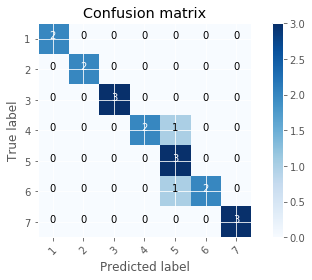

In [49]:
train,test = form_train_test_all_features(1)

X_train,Y_train,X_test,Y_test = form_X_Y_train_test_all_features(train,test)
    
clf = GaussianNB()
clf.fit(X_train, Y_train.ravel())
target_pred_train = clf.predict(X_train)
target_pred_test = clf.predict(X_test)

cnf_matrix_test = confusion_matrix(Y_test, target_pred_test,labels=[1,2,3,4,5,6,7])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=[1,2,3,4,5,6,7],
                      title='Confusion matrix')

### Multinomial Priors Implementation - <br>
Note - I've made use print statements to track progress of the loop

In [60]:
multinomial_nbc_train_score = []
multinomial_nbc_test_score = []
multinomial_nbc_test_error = []
for i in range(1,21,1):
    train,test = form_train_test_all_features(i) #Obtaining the train and test data

    X_train,Y_train,X_test,Y_test = form_X_Y_train_test_all_features(train,test)
    
    clf = MultinomialNB() # Initialising the Naive Bayes' classifier using Multinomial priors 
    clf.fit(X_train, Y_train.ravel()) #Fitting the model to the training data
    target_pred = clf.predict(X_train) 
    
    # Calculating the test score
    test_score = clf.score(X_test, Y_test.ravel())
    test_error = 1-test_score # Calculating the test error
    
    multinomial_nbc_train_score.append(clf.score(X_train, Y_train.ravel()))
    multinomial_nbc_test_score.append(clf.score(X_test, Y_test.ravel()))
                           
    multinomial_nbc_test_error.append(test_error)                       

Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)
Length of Attributes: 85
(69, 85)
Length of Attributes: 85
(19, 85)
Length of Attributes: 127
(69, 127)
Length of Attributes: 127
(19, 127)
Length of Attributes: 169
(69, 169)
Length of Attributes: 169
(19, 169)
Length of Attributes: 211
(69, 211)
Length of Attributes: 211
(19, 211)
Length of Attributes: 253
(69, 253)
Length of Attributes: 253
(19, 253)
Length of Attributes: 295
(69, 295)
Length of Attributes: 295
(19, 295)
Length of Attributes: 337
(69, 337)
Length of Attributes: 337
(19, 337)
Length of Attributes: 379
(69, 379)
Length of Attributes: 379
(19, 379)
Length of Attributes: 421
(69, 421)
Length of Attributes: 421
(19, 421)
Length of Attributes: 463
(69, 463)
Length of Attributes: 463
(19, 463)
Length of Attributes: 505
(69, 505)
Length of Attributes: 505
(19, 505)
Length of Attributes: 547
(69, 547)
Length of Attributes: 547
(19, 547)
Length of Attributes: 589
(69, 589)
Length of Attributes: 589
(19, 589)


In [61]:
#Forming a Summary Dictionary
dict_summary_multinomial = {"Split": np.arange(1,21,1),
                         "Train Score":multinomial_nbc_train_score,
                         "Test Score":multinomial_nbc_test_score,
                         "Test Error":multinomial_nbc_test_error}

#Forming a Summary Dataframe
df_summary_multinomial = pd.DataFrame(dict_summary_multinomial)
df_summary_multinomial.style

#### Sorting the above dataframe by Test Score
From the below dataframe we can see that we achieve the highest test score when __l=1__(Number of times time series is split)

In [64]:
sorted_df = df_summary_multinomial.sort_values(by=['Test Score'],ascending=False)
sorted_df.head(1)

Split  Train Score  Test Score  Test Error
0      1     0.927536    0.894737    0.105263

### We obtain the highest test score for split l=1

#### Confusion Matrix for Test Data

Length of Attributes: 43
(69, 43)
Length of Attributes: 43
(19, 43)


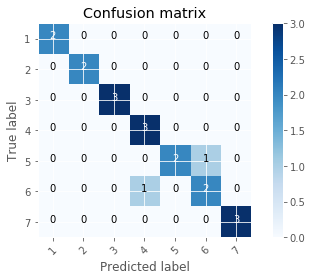

In [53]:
train,test = form_train_test_all_features(1)

X_train,Y_train,X_test,Y_test = form_X_Y_train_test_all_features(train,test)
    
clf = MultinomialNB()
clf.fit(X_train, Y_train.ravel())
target_pred_train = clf.predict(X_train)
target_pred_test = clf.predict(X_test)

cnf_matrix_test = confusion_matrix(Y_test, target_pred_test,labels=[1,2,3,4,5,6,7])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=[1,2,3,4,5,6,7],
                      title='Confusion matrix')

## Comparing the three methods of Multi Class Classification
__L1-Penalized Logistic Regression, Naive Bayes' Classifier using Gaussian and Multinomial priors__

### Forming a single data frame comparing the test errors of the above mentioned methods

In [106]:
dict_summary_classification = {"Split":np.arange(1,21),
                               "L1-Penalized Logistic Regression":test_score_multinomial,
                               "Naive Bayes' Classifier using Gaussian Implementation":gaussian_nbc_test_score,
                               "Naive Bayes' Classifier using Multinomial priors":multinomial_nbc_test_score}
df_summary_classification = pd.DataFrame(dict_summary_classification)
df_summary_classification.set_index('Split')
df_summary_classification.style

Comparing the test scores of the three methods, we can notice that the __best case in L1-Penalized Logistic Regression(Split =2)__ has the highest test score.<br><br>

To generalize, the test errors in both __L1-Penalized Logistic Regression__ and __Naive Bayes' Classifier using Multinomial priors__ are very similar.

### Written section of the homework in the attached pdf